# Midterm Project - Titanic Dataset

### Data Dictionary

| Variable   | Definition                            | Key                            |
|------------|---------------------------------------|--------------------------------|
| survival   | Survival                              | 0 = No, 1 = Yes                |
| pclass     | Ticket class                          | 1 = 1st, 2 = 2nd, 3 = 3rd      |
| sex        | Sex                                   |                                |
| Age        | Age in years                          |                                |
| sibsp      | # of siblings/spouses aboard Titanic  |                                |
| parch      | # of parents/children aboard Titanic  |                                |
| ticket     | Ticket number                         |                                |
| fare       | Passenger fare                        |                                |
| cabin      | Cabin number                          |                                |
| embarked   | Port of Embarkation                   | C = Cherbourg, Q = Queenstown, S = Southampton |


# 1. Problem Definition

### Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
### Specific Task: find patterns in train.csv that help predict whether the passengers in test.csv survived.

# 2. Data Collection and Exploration

In [171]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# models and algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Load the Dataset
train_df = pd.read_csv('data/train/train.csv')
test_df = pd.read_csv('data/test/test.csv')
combine_df = [train_df, test_df]



Training Dataset Features:
-------------------------
PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked

Test Dataset Features:
---------------------
PassengerId
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


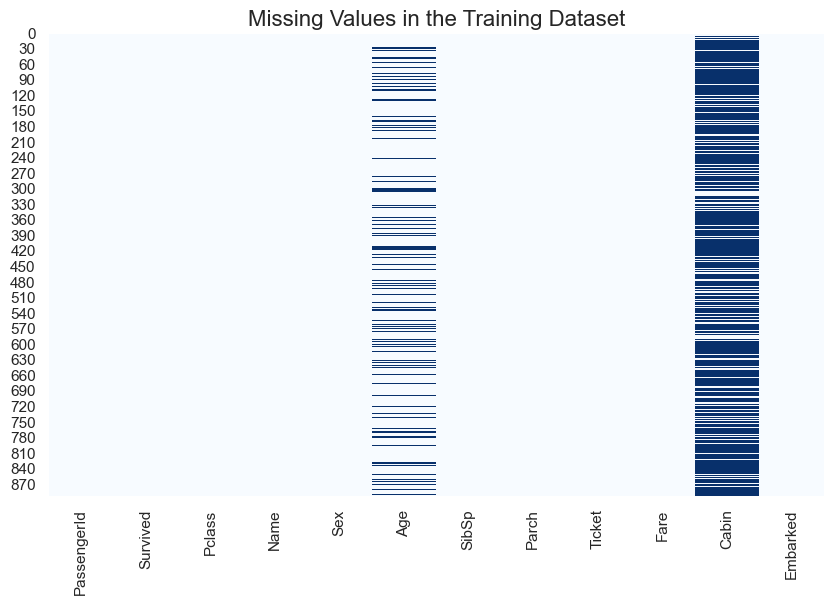

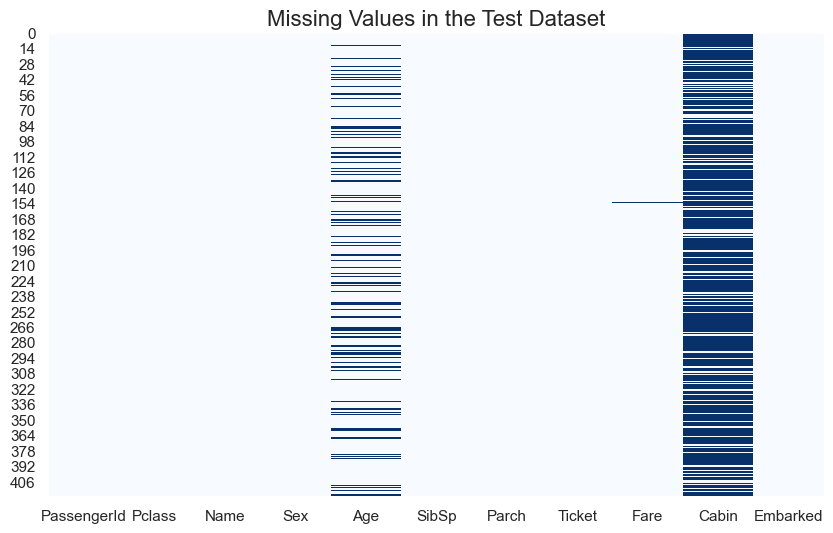

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000000,446.000000,257.353842,1.000000,223.500000,446.000000,668.500000,891.000000
Survived,891.000000,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200


,count,mean,std,min,25%,50%,75%,max
PassengerId,418.000000,1100.500000,120.810458,892.000000,996.250000,1100.500000,1204.750000,1309.000000
Pclass,418.000000,2.265550,0.841838,1.000000,1.000000,3.000000,3.000000,3.000000
Age,332.000000,30.272590,14.181209,0.170000,21.000000,27.000000,39.000000,76.000000
SibSp,418.000000,0.447368,0.896760,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,418.000000,0.392344,0.981429,0.000000,0.000000,0.000000,0.000000,9.000000
Fare,417.000000,35.627188,55.907576,0.000000,7.895800,14.454200,31.500000,512.329200


In [172]:
# Function to display the feature names
def display_feature_columns(df, title="Feature Names"):
    print(f"\n{title}:\n" + "-"*len(title))
    for column in df.columns:
        print(column)

# Function to visualize missing values, only if missing values exist
def visualize_missing_values(df, title="Missing Values in the Dataset"):
    if df.isnull().sum().sum() > 0:  # Check if there are any missing values
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap="Blues", annot=False)
        plt.title(title, fontsize=16)
        plt.show()
    else:
        print(f"No missing values to display for {title}.")

# Function to display summary statistics with gradient background
def display_summary_statistics(df, title="Dataset Summary", cmap="Blues"):
    summary = df.describe().transpose()
    return summary.style.background_gradient(cmap=cmap).set_caption(title)

# Call functions for train and test datasets

# 1. Display feature names
display_feature_columns(train_df, title="Training Dataset Features")
display_feature_columns(test_df, title="Test Dataset Features")

# 2. Visualize missing values
visualize_missing_values(train_df, title="Missing Values in the Training Dataset")
visualize_missing_values(test_df, title="Missing Values in the Test Dataset")

# 3. Show summary statistics with better formatting
train_summary_styled = display_summary_statistics(train_df, title="Training Data Summary", cmap="Blues")
test_summary_styled = display_summary_statistics(test_df, title="Test Data Summary", cmap="Greens")

# Display the styled summary
display(train_summary_styled)
display(test_summary_styled)


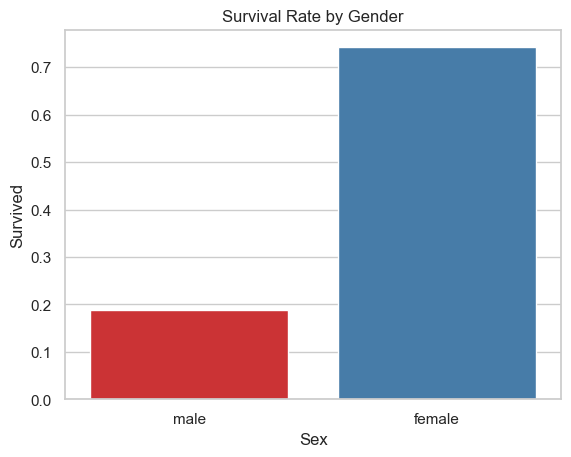

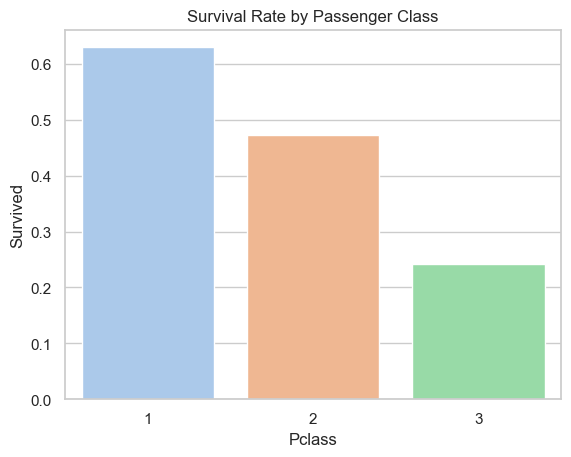

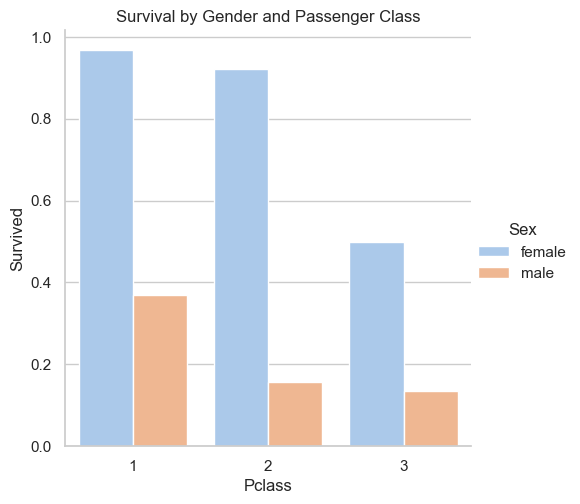

In [173]:
sns.set_theme(style="whitegrid")

# Plot survival rates by gender
# plt.figure(figsize=(6, 4))
# sns.countplot(x='Sex', hue='Survived', data=train_df, palette='Set1')
# plt.title("Survival Rates by Gender")
# plt.ylabel("Count")
# plt.show()

# Updated visualization for Survival Rate by Gender
sns.barplot(x='Sex', y='Survived', hue='Sex', data=train_df, errorbar=None, palette="Set1", legend=False)
plt.title("Survival Rate by Gender")
plt.show()

# Updated visualization for Survival by Passenger Class
sns.barplot(x='Pclass', y='Survived', hue='Pclass', data=train_df, errorbar=None, palette="pastel", legend=False)
plt.title("Survival Rate by Passenger Class")
plt.show()

# Survival by Gender and Passenger Class
sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_df, kind="bar", palette="pastel", errorbar=None)
plt.title("Survival by Gender and Passenger Class")
plt.show()


### Visualize Survival Rates by Passenger Class

#### Survival by Class: 
- There is a clear relationship between class and survival, with first-class passengers having the highest survival rate at 63%, followed by 2nd class (47%) and 3rd class (24%).

### Survival by Gender: 
- Women had a much higher survival rate (74%) compared to men (19%).
- The "women and children first" policy is clearly reflected in the survival rates. Nearly all first-class women survived, but survival for third-class women was much lower. Men in lower classes had the worst chances of survival.

### Visualize Survival Rates by Age

#### Survival by Age: 
- Younger passengers had a much higher survival rate, particularly children under 10 years old. Passengers over 70 had almost no chance of survival.

### Visualize Age Distribution of Passengers

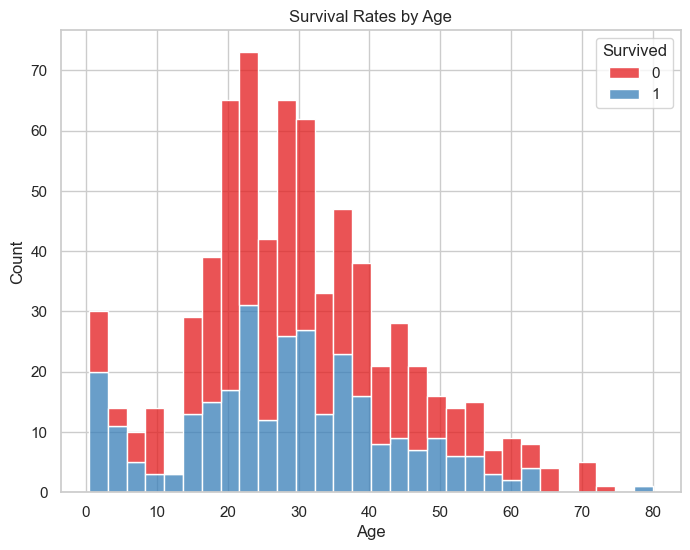

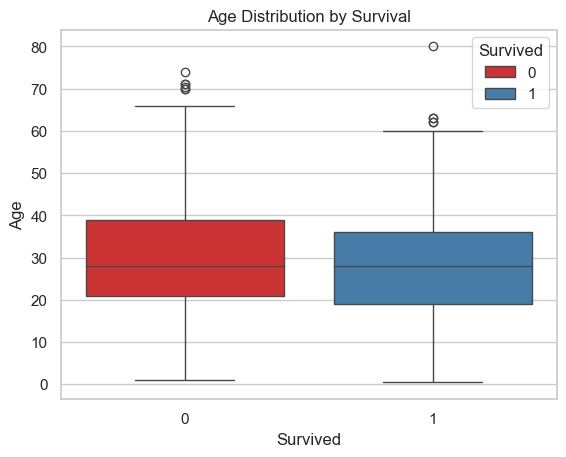

In [174]:
# Age Distribution and Survival Rates
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack', bins=30, palette='Set1')
plt.title("Survival Rates by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Updated visualization for Age Distribution by Survival
sns.boxplot(x='Survived', y='Age', hue='Survived', data=train_df, palette="Set1")
plt.title("Age Distribution by Survival")
plt.show()

#### The significantly higher survival rate for children supports the historical "women and children first" evacuation policy. Passengers over 70 faced slim chances of survival, likely due to limited mobility and other late-age factors.

In [175]:
# Display descriptive statistics for survived vs non-survived passengers
train_df.groupby('Survived')['Age'].describe()


,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


- The average age of passengers who survived was 28.3 years, while for those who did not survive, it was 30.6 years.
- Median ages for both groups were close, but the distribution of age for survivors was slightly more skewed towards younger passengers.

- Younger passengers, particularly children under 10, had a much higher chance of survival, reinforcing the "women and children first" policy. The difference in median ages between survivors and non-survivors is not large, but younger age clearly played a role in survivability.

# 3. Feature Engineering

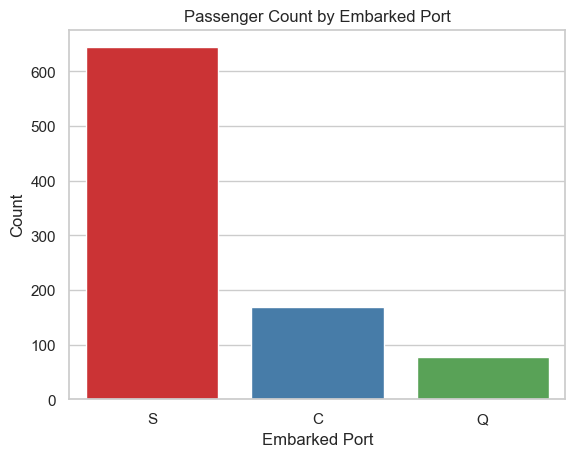

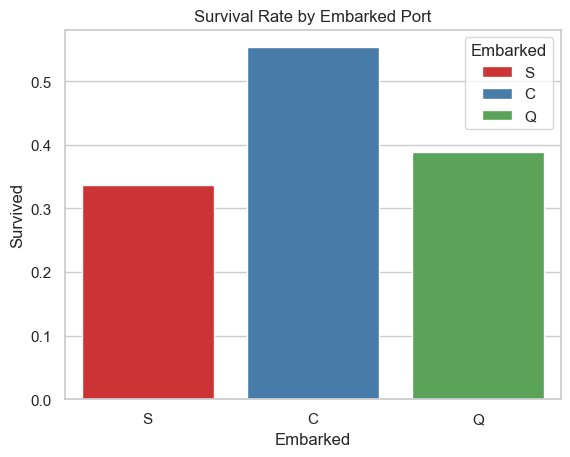

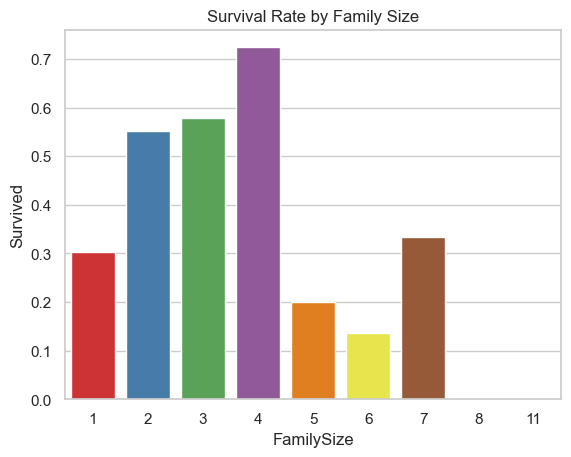

In [176]:
# Preprocessing function to handle missing values, encoding, and scaling
def preprocess_data(df, is_train=True):
    # Fill missing age values with the median
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Fill missing embarked values with the most common value
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Fill missing fare values with the median (important for test data)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Create a new feature 'CabinAvailable' to indicate whether cabin info is available
    df['CabinAvailable'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

    # Family Size: Combine SibSp and Parch into a single feature, FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Extract title from the Name column (e.g., Mr., Mrs., Miss)
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

    # Drop unnecessary columns ('Name', 'Ticket', 'Cabin', 'PassengerId')
    columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    df = df.drop(columns_to_drop, axis=1, errors='ignore')

    # Encode categorical variables (Sex, Embarked, Title)
    df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

    # Scale continuous variables (Fare and Age)
    scaler = StandardScaler()
    df[['Fare', 'Age']] = scaler.fit_transform(df[['Fare', 'Age']])

    return df

# Load the train and test datasets
# train_df = pd.read_csv('data/train/train.csv')
# test_df = pd.read_csv('data/test/test.csv')

# Store PassengerId from test_df before preprocessing
passenger_id_test = test_df['PassengerId'].copy()

# Visualizing Embarkation Port Counts
x = 'hue'
sns.countplot(x='Embarked', data=train_df, hue='Embarked', palette="Set1", legend=False)
plt.title("Passenger Count by Embarked Port")
plt.xlabel("Embarked Port")
plt.ylabel("Count")
plt.show()

# Survival by Embarkation Port
sns.barplot(x='Embarked', y='Survived', hue='Embarked', data=train_df, errorbar=None, palette="Set1")
plt.title("Survival Rate by Embarked Port")
plt.show()

# Apply preprocessing to both train and test datasets
train_df = preprocess_data(train_df, is_train=True)
test_df = preprocess_data(test_df, is_train=False)

# Visualize FamilySize vs Survived
sns.barplot(x='FamilySize', y='Survived', hue='FamilySize', data=train_df, errorbar=None, palette="Set1", legend=False)
plt.title("Survival Rate by Family Size")
plt.show()

# Define features and target variable for training
y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis=1)

# Align test set with the training set columns
train_columns = X_train.columns
X_test = test_df.copy()

# Add missing columns in the test set
for col in train_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Ensure test set has the same columns as the train set
X_test = X_test[train_columns]


# Step 4: Model Building

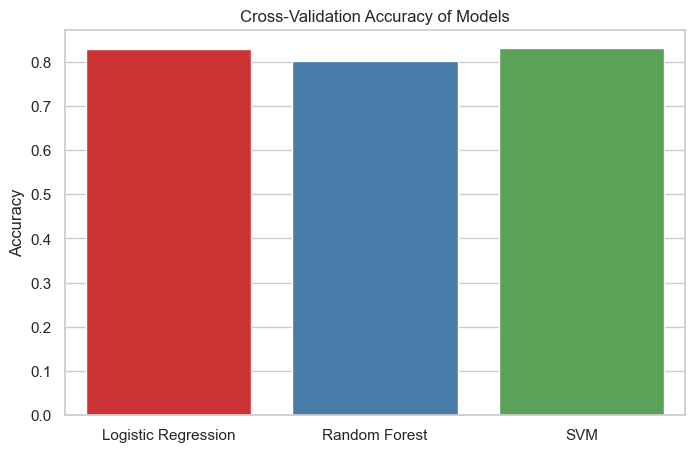

In [177]:
# Select and Initialize models
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC()

# Cross-validate Logistic Regression
cv_scores_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
logreg_accuracy = cv_scores_logreg.mean()

# Cross-validate Random Forest
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
rf_accuracy = cv_scores_rf.mean()

# Cross-validate SVM
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
svm_accuracy = cv_scores_svm.mean()

model_performance = {
    'Logistic Regression': logreg_accuracy,
    'Random Forest': rf_accuracy,
    'SVM': svm_accuracy
}

# Create a bar chart for model performance
plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_performance.keys()), y=list(model_performance.values()), hue=model_performance.keys(), legend=False, palette='Set1')
plt.title("Cross-Validation Accuracy of Models")
plt.ylabel("Accuracy")
plt.show()


### Hyperparameter Tuning

In [178]:
# Step 1: Define parameter grids for each model

# Logistic Regression parameters
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Random Forest parameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# SVM parameters
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Step 2: Hyperparameter tuning with GridSearchCV

# Logistic Regression tuning
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)

# Random Forest tuning
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# SVM tuning
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

# 5. Model Evaluation - Precision, Cross Validation

In [179]:
# 5. Model Evaluation - Precision, Cross Validation
best_params = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Best Parameters': [grid_search_logreg.best_params_, grid_search_rf.best_params_, grid_search_svm.best_params_],
    'Best CV Accuracy': [grid_search_logreg.best_score_, grid_search_rf.best_score_, grid_search_svm.best_score_]
}

# Display the best parameters and cross-validation score for each model
best_params_df = pd.DataFrame(best_params)
display(best_params_df)


,Model,Best Parameters,Best CV Accuracy
0,Logistic Regression,"{'C': 1, 'solver': 'lbfgs'}",0.830507
1,Random Forest,"{'max_depth': None, 'min_samples_split': 10, '...",0.829408
2,SVM,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.836118


# 6. Generate Predictions Using the Best SVM Model

In [180]:
# Final Model and Prediction
best_model = grid_search_svm.best_estimator_
y_pred_final = best_model.predict(X_test)


# 7. Prepare Submission Dataframe

In [181]:
# Prepare and visualize the submission
submission = pd.DataFrame({
    "PassengerId": passenger_id_test,
    "Survived": y_pred_final
})

# Save to CSV
submission.to_csv('titanic_submission.csv', index=False)

# Confirmation output
print("Submission file 'titanic_submission.csv' generated successfully.")

Submission file 'titanic_submission.csv' generated successfully.
